In [1]:
import SimpleITK as sitk
import json
import numpy as np
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pydicom

CASE_PATH = r'C:\Users\ang.a\OneDrive - Technion\Documents\MRI_Data\clean cases\75'
ANNOTATION_DATA = r'C:\Users\ang.a\OneDrive - Technion\Documents\MRI_Data\clean cases\75\data\24.11.2021__12_20..annotation.json'

In [2]:
# transform slice location data in header to slice indices
slice_locations = []
for i in glob(f'{CASE_PATH}\*.dcm'):
    f = Path(i)
    header = pydicom.dcmread(f)
    
    slice_locations.append(float(header['SliceLocation'].value))

slice_locations = dict(enumerate(sorted(slice_locations)))
slice_locations = dict([(value, key) for key, value in slice_locations.items()])

In [3]:
# open and read the annotation data
with open(ANNOTATION_DATA, 'r') as f: 
    annotation_points = json.load(f)
    data = annotation_points['MPR points']

data = np.array(data)
data[-1] 

array([-25.24496122, -77.65830928,  -1.54895592])

In [4]:
# get the slice indices that have annotations...
indices = [slice_locations[z] for z in np.unique(data[:,2])]
print(indices)

# and include the un-annotated slices in between
indices = list(range(indices[0], indices[-1]+1))
print(indices)

[13, 14, 15, 16, 17, 18]
[13, 14, 15, 16, 17, 18]


In [5]:
# convert the last coordinate to the slice index
data_copy = np.copy(data)

for i in data_copy:
    i[2] = slice_locations[i[2]]

In [6]:
# transform the DICOM folder to a numpy array
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(CASE_PATH)
reader.SetFileNames(dicom_names)
image = reader.Execute()
nda = sitk.GetArrayFromImage(image)

# nda = np.flipud(nda)
# nda = np.reshape(nda, nda.shape, order='F')

In [15]:
dicom_names

('C:\\Users\\ang.a\\OneDrive - Technion\\Documents\\MRI_Data\\clean cases\\75/1.2.840.113619.2.244.6945.297090.20976.1325225351.798.dcm_enc.dcm',
 'C:\\Users\\ang.a\\OneDrive - Technion\\Documents\\MRI_Data\\clean cases\\75/1.2.840.113619.2.244.6945.297090.20976.1325225351.802.dcm_enc.dcm',
 'C:\\Users\\ang.a\\OneDrive - Technion\\Documents\\MRI_Data\\clean cases\\75/1.2.840.113619.2.244.6945.297090.20976.1325225351.799.dcm_enc.dcm',
 'C:\\Users\\ang.a\\OneDrive - Technion\\Documents\\MRI_Data\\clean cases\\75/1.2.840.113619.2.244.6945.297090.20976.1325225351.803.dcm_enc.dcm',
 'C:\\Users\\ang.a\\OneDrive - Technion\\Documents\\MRI_Data\\clean cases\\75/1.2.840.113619.2.244.6945.297090.20976.1325225351.800.dcm_enc.dcm',
 'C:\\Users\\ang.a\\OneDrive - Technion\\Documents\\MRI_Data\\clean cases\\75/1.2.840.113619.2.244.6945.297090.20976.1325225351.804.dcm_enc.dcm',
 'C:\\Users\\ang.a\\OneDrive - Technion\\Documents\\MRI_Data\\clean cases\\75/1.2.840.113619.2.244.6945.297090.20976.1325225

In [7]:
dir(image)

['CopyInformation',
 'EraseMetaData',
 'GetDepth',
 'GetDimension',
 'GetDirection',
 'GetHeight',
 'GetITKBase',
 'GetMetaData',
 'GetMetaDataKeys',
 'GetNumberOfComponentsPerPixel',
 'GetNumberOfPixels',
 'GetOrigin',
 'GetPixel',
 'GetPixelAsComplexFloat64',
 'GetPixelID',
 'GetPixelIDTypeAsString',
 'GetPixelIDValue',
 'GetSize',
 'GetSpacing',
 'GetWidth',
 'HasMetaDataKey',
 'IsUnique',
 'MakeUnique',
 'SetDirection',
 'SetMetaData',
 'SetOrigin',
 'SetPixel',
 'SetPixelAsComplexFloat64',
 'SetSpacing',
 'TransformContinuousIndexToPhysicalPoint',
 'TransformIndexToPhysicalPoint',
 'TransformPhysicalPointToContinuousIndex',
 'TransformPhysicalPointToIndex',
 '_Image__ipaste',
 '__GetPixelAsComplexFloat32__',
 '__GetPixelAsDouble__',
 '__GetPixelAsFloat__',
 '__GetPixelAsInt16__',
 '__GetPixelAsInt32__',
 '__GetPixelAsInt64__',
 '__GetPixelAsInt8__',
 '__GetPixelAsUInt16__',
 '__GetPixelAsUInt32__',
 '__GetPixelAsUInt64__',
 '__GetPixelAsUInt8__',
 '__GetPixelAsVectorFloat32__',
 '

In [14]:
direction = np.array(image.GetDirection()).reshape(3,3)

direction

array([[ 0.99998896,  0.        , -0.0046998 ],
       [ 0.0046998 ,  0.        ,  0.99998896],
       [ 0.        , -1.        ,  0.        ]])

In [9]:
x_num = image.GetSize()[0]
xi = -1 * image.GetSpacing()[0]*image.GetWidth()/2
xf = 1 * image.GetSpacing()[0]*image.GetWidth()/2

y_num = image.GetSize()[1]
yi = -1 * image.GetSpacing()[1]*image.GetHeight()/2
yf = 1 * image.GetSpacing()[1]*image.GetHeight()/2

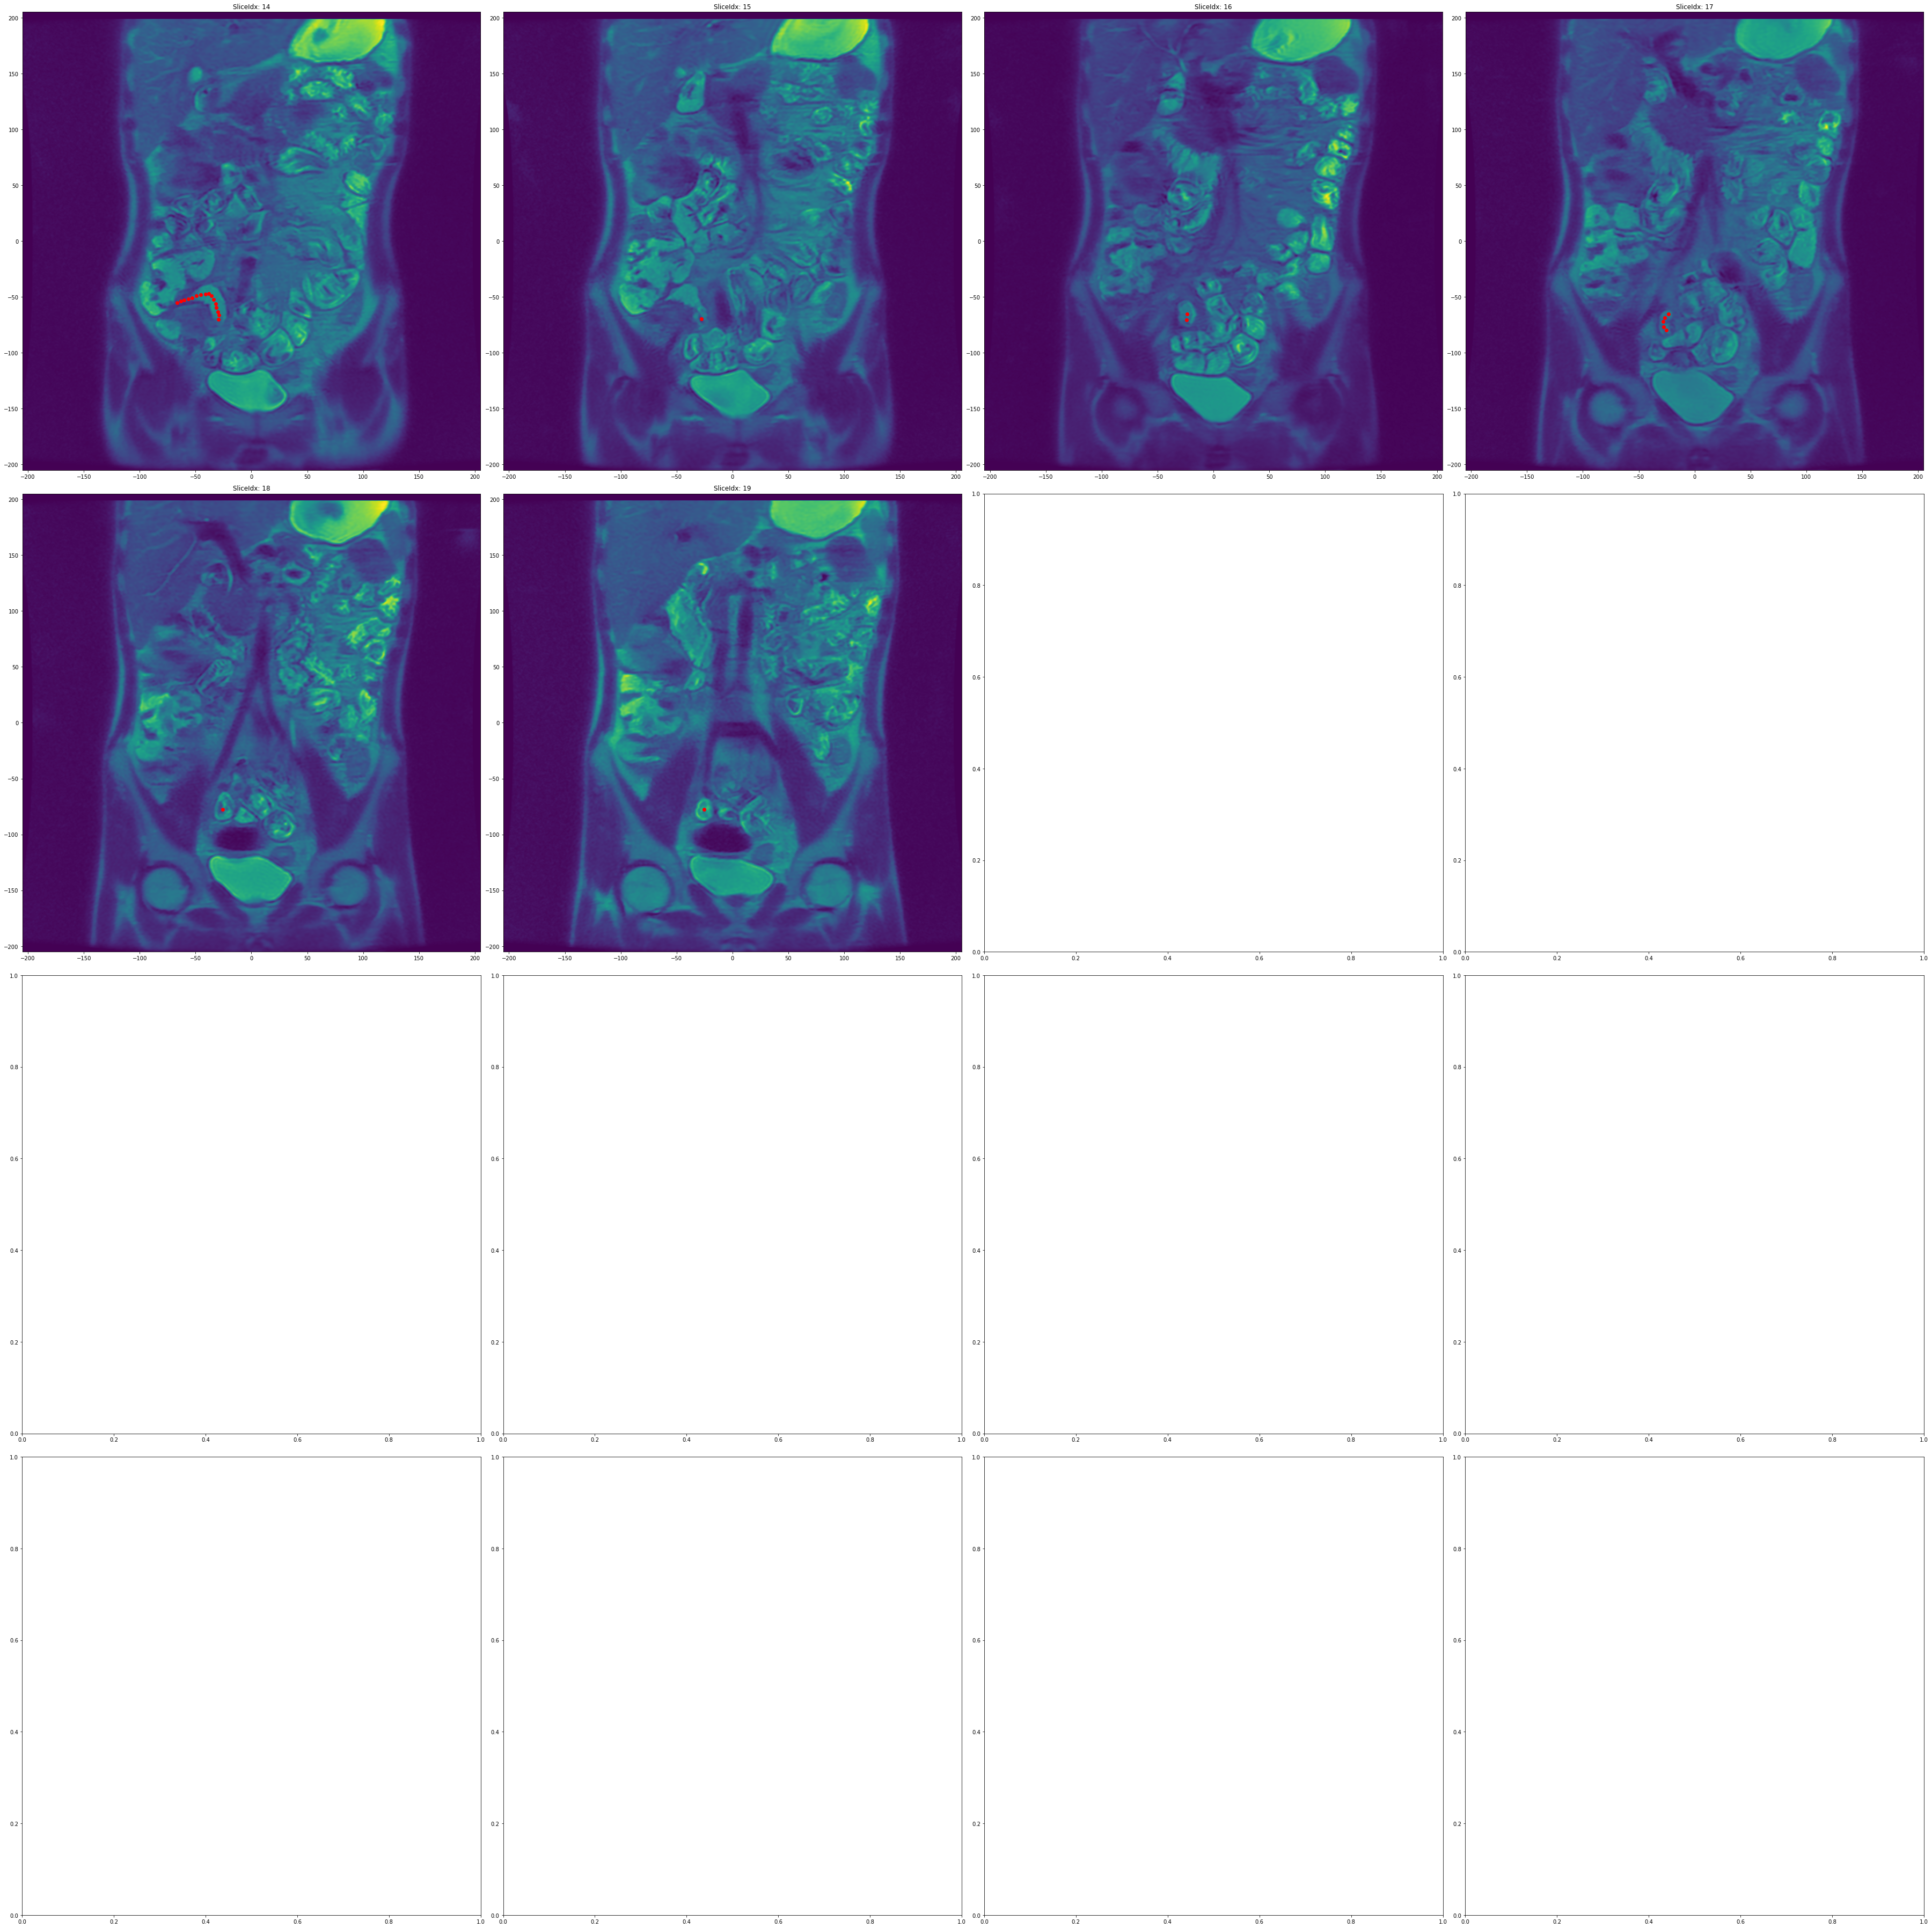

In [10]:
# show all slices
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(50,50))

axs = np.ravel(axs)

slice_translate = 1
for idx, i in enumerate(indices):
    axs[idx].set_title(f'SliceIdx: {i+slice_translate}')
    axs[idx].imshow(nda[i+slice_translate,:,:], extent=[xi,xf,yi,yf])

    for pt in data_copy:
        if pt[2] == i:
            axs[idx].plot(pt[0], pt[1], 'ro')
plt.tight_layout()
